### Import required libraries


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('future.no_silent_downcasting', True)

### Part I: Preprocessing and Exploratory Data Analysis (EDA)

In [6]:
# Options to display all columns
pd.options.display.max_columns = None

# read the csv file into dataframe
raw_orders = pd.read_csv('./../data/raw/Orders.csv')
raw_returns = pd.read_csv('./../data/raw/Returns.csv')

# Lets make a copy and work on it
orders = raw_orders.copy(deep = True)
returns = raw_returns.copy(deep = True)

In [7]:
# lets lower all column names for convenience
orders.columns = map(lambda col: col.lower(), orders.columns)
returns.columns = map(lambda col: col.lower(), returns.columns)

In [8]:
# Lets peek into data types of each column in orders
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   row.id          51290 non-null  int64  
 1   order.id        51290 non-null  object 
 2   order.date      51290 non-null  object 
 3   ship.date       51290 non-null  object 
 4   ship.mode       51290 non-null  object 
 5   customer.id     51290 non-null  object 
 6   customer.name   51290 non-null  object 
 7   segment         51290 non-null  object 
 8   postal.code     9994 non-null   float64
 9   city            51290 non-null  object 
 10  state           51290 non-null  object 
 11  country         51290 non-null  object 
 12  region          51290 non-null  object 
 13  market          51290 non-null  object 
 14  product.id      51290 non-null  object 
 15  category        51290 non-null  object 
 16  sub.category    51290 non-null  object 
 17  product.name    51290 non-null 

In [9]:
# Convert profits and sales into numeric columns
def clean_orders_data(raw_df):
    """Clean the orders raw data and return the orders cleaned data"""
    
    # Initialize clean_df as a copy of raw_df
    clean_df = raw_df.copy()

    # Clean profits and sales columns
    clean_df[['sales', 'profit']] = clean_df[['sales', 'profit']].apply(lambda col: pd.to_numeric(col.str.replace(r'[\$|,]', '', regex = True)))

    return clean_df

Apply data cleaning function to convert sales and profit to numeric columns:

In [10]:
orders = clean_orders_data(orders)
orders[['sales', 'profit']].head(2)

,sales,profit
0,221.98,62.15
1,3709.40,-288.77


Examine if we have columns with null values in orders:

In [11]:
orders.isnull().sum(axis=0)

row.id                0
order.id              0
order.date            0
ship.date             0
ship.mode             0
customer.id           0
customer.name         0
segment               0
postal.code       41296
city                  0
state                 0
country               0
region                0
market                0
product.id            0
category              0
sub.category          0
product.name          0
sales                 0
quantity              0
discount              0
profit                0
shipping.cost         0
order.priority        0
dtype: int64

In [12]:
# Lets peek into data types of each column in returns
returns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1079 entries, 0 to 1078
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   returned  1079 non-null   object
 1   order id  1079 non-null   object
 2   region    1079 non-null   object
dtypes: object(3)
memory usage: 25.4+ KB


There are no missing values all columns. Lets transform returned column to bool type and examine if region category is clean (no two or more names for same region etc.).

In [13]:
# convert returned column to bool type
returns['returned'].str.lower().replace("yes", True)

# Lets look at how many regions we have and frequency return for each region
returns['region'].value_counts()

region
Western Europe       121
Central America      117
Oceania               78
Western US            72
Eastern US            69
Southeastern Asia     64
South America         61
Southern Asia         58
Southern Europe       55
Eastern Asia          53
Western Asia          50
Southern US           44
Northern Europe       43
Central US            42
Caribbean             31
Western Africa        29
North Africa          26
Eastern Europe        24
Southern Africa       11
Eastern Africa        11
Central Africa        10
Eastern Canada         5
Central Asia           4
Western Canada         1
Name: count, dtype: int64

In [14]:
def clean_returns_data(raw_df):
    clean_df = raw_df.copy()
    # convert returned column to bool type
    clean_df['returned'] = clean_df['returned'].str.lower().replace("yes", True)
    # clean column names, rename 'order id' to 'order.id'
    clean_df.rename(columns = {'order id': 'order.id'}, inplace = True)
    # since orders has 'Canada' region only but returns has both 'Eastern Canada' and 'Western Canada'
    # lets resolve that issue by making both Eastern and Western Canada as Canada only
    clean_df['region'].replace({'Eastern Canada': 'Canada', 'Western Canada': 'Canada'}, inplace = True)
    return clean_df

In [15]:
# lets store cleaned data in returns
returns = clean_returns_data(returns)

C:\Users\anita\AppData\Local\Temp\ipykernel_13476\3895563992.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clean_df['region'].replace({'Eastern Canada': 'Canada', 'Western Canada': 'Canada'}, inplace = True)


- Retailers that depend on seasonal shoppers have a particularly challenging job when it comes to inventory management. Let say we are making plans for next year's inventory.
- We want to answer the following questions:
    1. Is there any seasonal trend of inventory in the company?
    2. Is the seasonal trend the same for different categories?

In [16]:
# lets convert order.date to datetime object, use %y for 2-digit year
print('order.date date type before cleaning ->', orders['order.date'].dtype)
print(orders['order.date'].head(1))

orders['order.date'] = pd.to_datetime(orders['order.date'], format = '%m/%d/%y')
print('order.date date type after cleaning ->', orders['order.date'].dtype)

order.date date type before cleaning -> object
0    11/11/14
Name: order.date, dtype: object
order.date date type after cleaning -> datetime64[ns]


Create new features like year, month, week, dayofyear etc. from order.date columns:

In [17]:
orders['order.year'] = orders['order.date'].dt.year
orders['order.month'] = orders['order.date'].dt.month
orders['order.week'] = orders['order.date'].dt.isocalendar().week
orders['order.dayofyear'] = orders['order.date'].dt.dayofyear

print("Newly added time column features:", '\n', orders[['order.date','order.year', 'order.month', 'order.week', 'order.dayofyear']].head(3))

Newly added time column features: 
   order.date  order.year  order.month  order.week  order.dayofyear
0 2014-11-11        2014           11          46              315
1 2014-02-05        2014            2           6               36
2 2014-10-17        2014           10          42              290


Lets create a dataframe that contains order.year as columns and order.dayofyear as index and each column values are sum of orders for each day in a given year. We can use unstack() after groupby to pivot index to columns.

In [18]:
day_df = orders.groupby(['order.dayofyear', 'order.year'])['quantity'].sum().unstack('order.year')

# Mean of products for each day across all years
day_df["mean"] = day_df.mean(axis = 1)

# Lets look at day_df data
day_df.head()

order.year,2012,2013,2014,2015,mean
order.dayofyear,,,,,
1,19.0,120.0,86.0,77.0,75.50
2,1.0,68.0,106.0,118.0,73.25
3,48.0,73.0,83.0,174.0,94.50
4,52.0,109.0,127.0,58.0,86.50
5,24.0,35.0,50.0,19.0,32.00


<Axes: title={'center': 'Total Number of Orders Per Day for a Year'}, xlabel='order.dayofyear', ylabel='Total Number of Orders'>

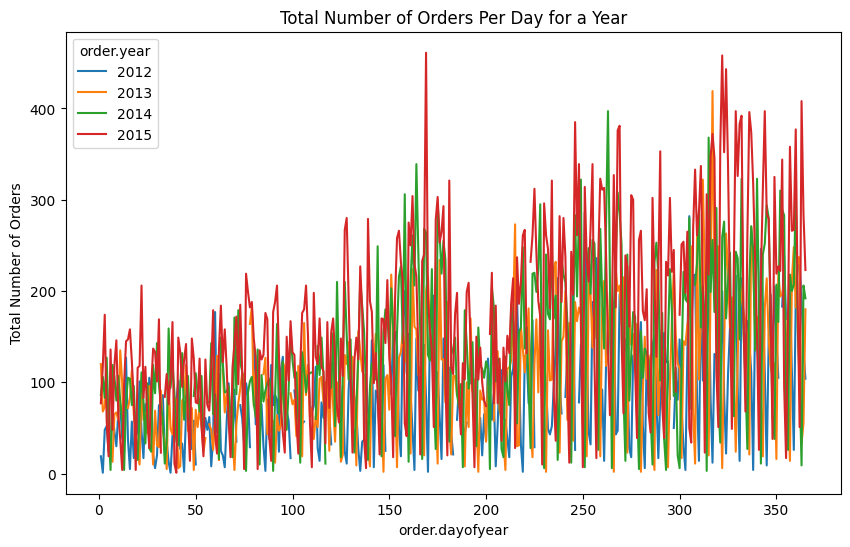

In [19]:
day_df.iloc[:,:-1].plot(figsize= (10, 6), title= 'Total Number of Orders Per Day for a Year', ylabel= 'Total Number of Orders')

<Axes: title={'center': 'Average Number of Total Orders per Day from Year 2012-2015'}, xlabel='order.dayofyear', ylabel='Average Number of Total Orders'>

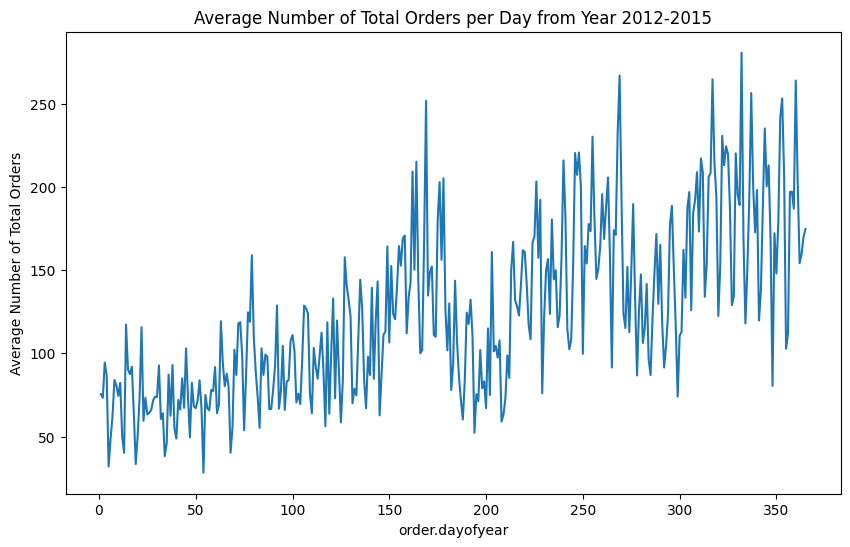

In [20]:
day_df.iloc[:,-1].plot(figsize= (10, 6), title= 'Average Number of Total Orders per Day from Year 2012-2015',
 ylabel= 'Average Number of Total Orders')

The daily chart seems to show some seasonality trends but its a bit noisy due to high frequency. Moreover, daily frequency seems too granular for inventory management. Lets reproduce the above results for lower temporal frequency (week, month).

In [21]:
week_df = orders.groupby(['order.week', 'order.year'])['quantity'].sum().unstack('order.year')

# Mean of products for each week across all years
week_df["mean"] = week_df.mean(axis = 1)

# Lets look at week_df data
week_df.head()

order.year,2012,2013,2014,2015,mean
order.week,,,,,
1,262.0,672.0,859.0,427.0,555.00
2,410.0,464.0,553.0,571.0,499.50
3,313.0,404.0,506.0,755.0,494.50
4,364.0,430.0,430.0,706.0,482.50
5,306.0,311.0,606.0,686.0,477.25


<Axes: title={'center': 'Total Number of Orders Per Week for a Year'}, xlabel='order.week', ylabel='Total Number of Orders'>

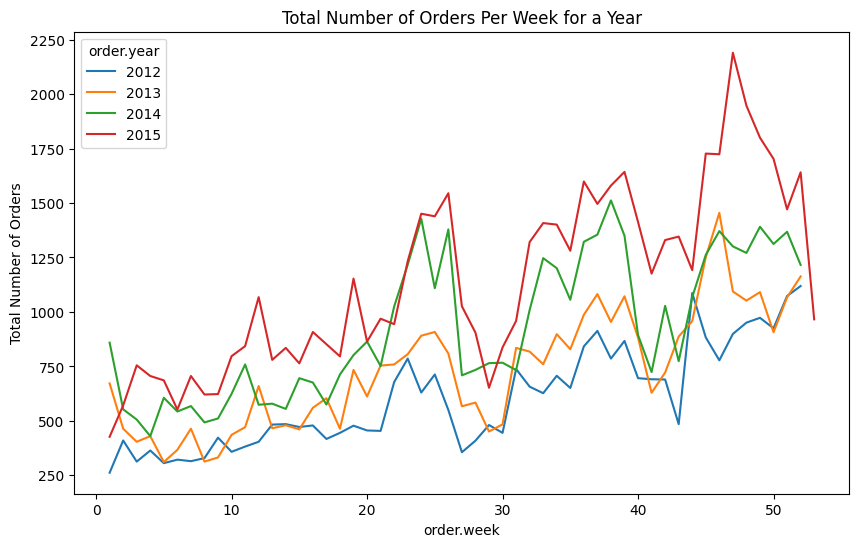

In [22]:
week_df.iloc[:,:-1].plot(figsize= (10, 6), title= 'Total Number of Orders Per Week for a Year', ylabel= 'Total Number of Orders')

<Axes: title={'center': 'Average Number of Total Orders per Week from Year 2012-2015'}, xlabel='order.week', ylabel='Average Number of Total Orders'>

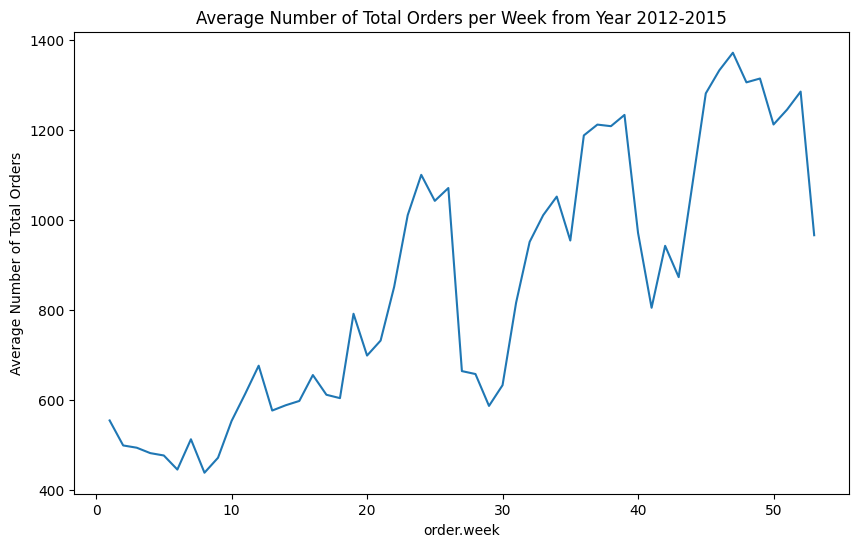

In [23]:
week_df.iloc[:,-1].plot(figsize= (10, 6), title= 'Average Number of Total Orders per Week from Year 2012-2015',
 ylabel= 'Average Number of Total Orders')

This week analysis shows some seasonality trends and it looks more clearer and relevant than the daily analysis. The trend is generally consistent across years. Mean of total orders seems like a good summary.

In [24]:
month_df = orders.groupby(['order.month', 'order.year'])['quantity'].sum().unstack('order.year')

# Mean of products for each week across all years
month_df["mean"] = month_df.mean(axis = 1)

# Lets look at week_df data
month_df.head()

order.year,2012,2013,2014,2015,mean
order.month,,,,,
1,1463,1874,2413,3122,2218.00
2,1401,1444,2102,2482,1857.25
3,1745,2237,2686,3722,2597.50
4,1934,2250,2688,3594,2616.50
5,2167,2921,3808,4300,3299.00


<Axes: title={'center': 'Total Number of Orders Per Month for a Year'}, xlabel='order.month', ylabel='Total Number of Orders'>

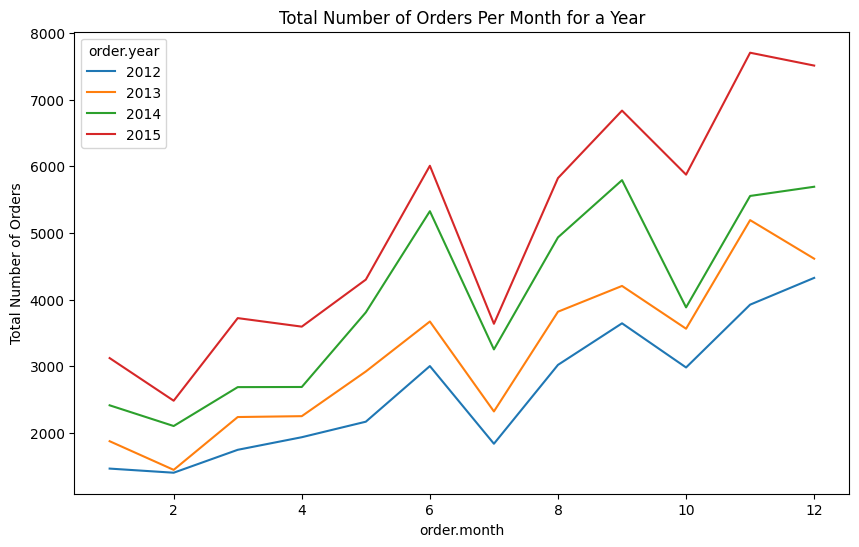

In [25]:
month_df.iloc[:,:-1].plot(figsize= (10, 6), title= 'Total Number of Orders Per Month for a Year', ylabel= 'Total Number of Orders')

<Axes: title={'center': 'Average Number of Total Orders per Month from Year 2012-2015'}, xlabel='order.month', ylabel='Average Number of Total Orders'>

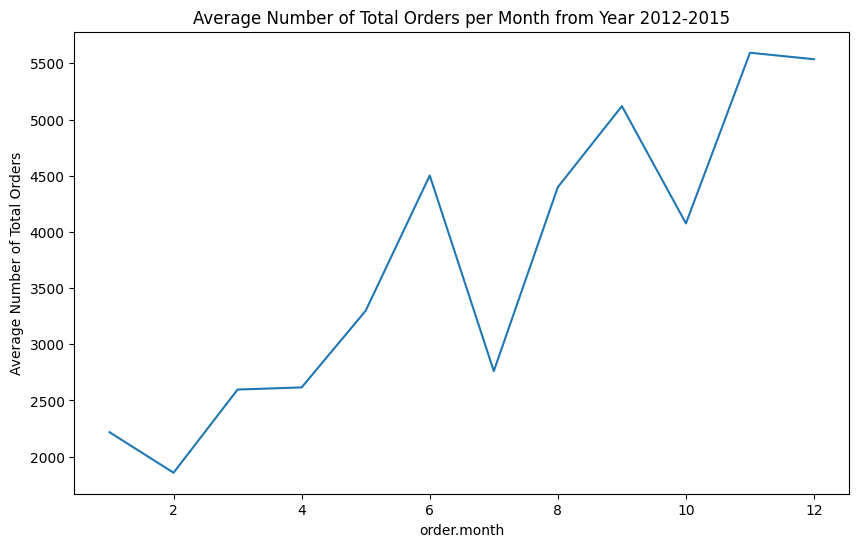

In [26]:
month_df.iloc[:,-1].plot(figsize= (10, 6), title= 'Average Number of Total Orders per Month from Year 2012-2015',
 ylabel= 'Average Number of Total Orders')

Although daily, weekly and monthly trends are consistent in showing seasonality trend however weekly and monthly are better for seasonality analysis for inventory management (our problem at hand).

To examine whether seasonal trend is same for different categories knowing average of trends across given years is a good summary, we can calculate for each category, the means of total order per month across given years.

category     Furniture  Office Supplies  Technology
order.month                                        
1               437.50          1370.00      410.50
2               373.50          1085.00      398.75
3               524.50          1570.75      502.25
4               501.25          1597.75      517.50
5               621.00          2042.50      635.50
6               858.50          2753.00      890.75
7               539.25          1654.50      567.75
8               764.75          2754.75      879.50
9              1027.75          3143.00      949.00
10              830.75          2396.25      848.75
11             1117.75          3382.25     1094.75
12             1126.50          3311.25     1099.00/n/n

<Axes: title={'center': 'Scaled Average orders by month for each category'}, xlabel='order.month'>

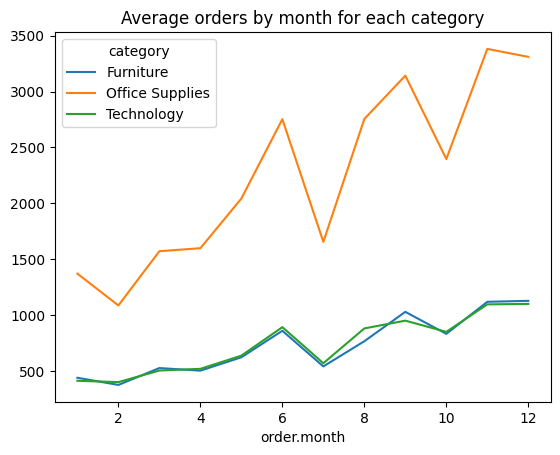

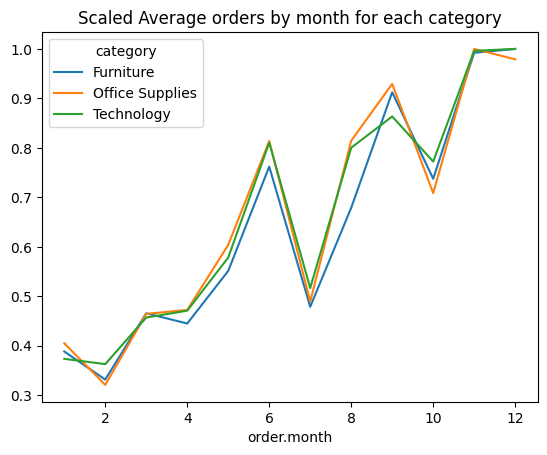

In [27]:
df = orders.groupby(['order.year', 'order.month', 'category'])['quantity'].sum().unstack('order.year').mean(axis = 1).unstack('category')
print(df, end = '/n/n')
# Lets normalize by max of order so we can compare seasonality across products
df_scaled = df.apply(lambda col: col/col.max())

# Plot average orders by month for each category
df.plot(title = 'Average orders by month for each category')

# Plot scaled average orders by month for each category
df_scaled.plot(title = 'Scaled Average orders by month for each category')

The central question is why did the customers return the order, how frequently and the revenue lost due to returns.

1. How much profit did we lose due to returns each year?

2. How many customer returned more than once? more than 5 times?

3. Which regions are more likely to return orders?

4. Which categories (sub-categories) of products are more likely to be returned?

In [28]:
# merge orders and return data frames using order.id which is a common column for orders
# and orders has 'region' so we can use only two columns in returns, use 'left-join' so we can
# have all orders data with profit and whether they were returned

# Note: An order_id is not unique, with same order_id (at one purchase), you can buy multiple
# items, when we merge we will see the number of returns product greater than shape of returns dataframe
orders_merged = pd.merge(orders, returns, on = ['order.id', 'region'], how = 'left')

# look into merged data
orders_merged.head(3)

,row.id,order.id,order.date,ship.date,ship.mode,customer.id,customer.name,segment,postal.code,city,state,country,region,market,product.id,category,sub.category,product.name,sales,quantity,discount,profit,shipping.cost,order.priority,order.year,order.month,order.week,order.dayofyear,returned
0,40098,CA-2014-AB10015140-41954,2014-11-11,11/13/14,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High,2014,11,46,315,NaN
1,26341,IN-2014-JR162107-41675,2014-02-05,2/7/14,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical,2014,2,6,36,NaN
2,25330,IN-2014-CR127307-41929,2014-10-17,10/18/14,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium,2014,10,42,290,NaN


Lets calculate the potential profit, profit lost, actual profit from the above data for each year.

In [29]:
profit_df = orders_merged[['order.year', 'profit']].groupby('order.year').agg(
    potential_profit = ('profit', 'sum'))

orders_returned = orders_merged[orders_merged['returned'] == True].reset_index(drop = True)

profit_df['profit_loss'] = orders_returned.groupby('order.year')['profit'].sum()
profit_df['profit_loss(%)'] = 100. * profit_df['profit_loss']/profit_df['potential_profit']
profit_df['actual_profit'] = profit_df['potential_profit'] - profit_df['profit_loss']
profit_df['actual_profit(%)'] = 100. - profit_df['profit_loss(%)']

In [30]:
profit_df

,potential_profit,profit_loss,profit_loss(%),actual_profit,actual_profit(%)
order.year,,,,,
2012,248940.35,17477.26,7.020662,231463.09,92.979338
2013,307415.33,9271.66,3.016004,298143.67,96.983996
2014,406934.89,17510.63,4.303054,389424.26,95.696946
2015,504166.10,17118.61,3.395431,487047.49,96.604569


Lets visualize the profit loss metric by year.

<Axes: title={'center': 'Profit Loss by Year'}, xlabel='order.year', ylabel='Profit [USD]'>

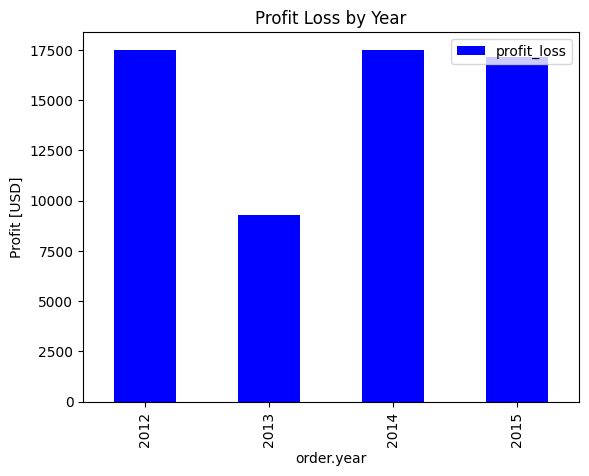

In [31]:
profit_df.plot.bar(y = 'profit_loss', color = 'blue', title = 'Profit Loss by Year', ylabel = 'Profit [USD]')

<Axes: title={'center': 'Profit Loss Percentage by Year'}, xlabel='order.year', ylabel='Profit Loss [%]'>

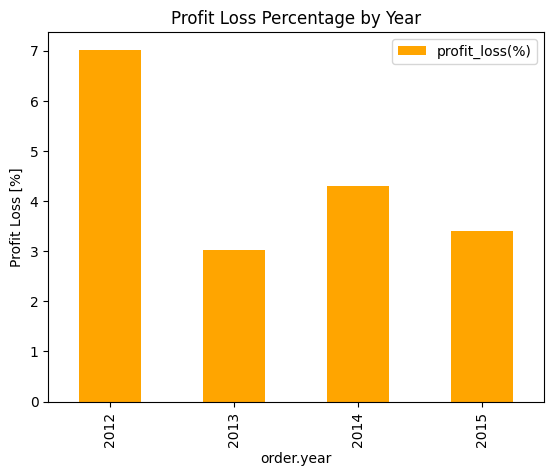

In [32]:
profit_df.plot.bar(y = 'profit_loss(%)', color = 'orange', title = 'Profit Loss Percentage by Year', ylabel = 'Profit Loss [%]')

<Axes: title={'center': 'Profit Loss by Year'}, xlabel='order.year', ylabel='Profit [USD]'>

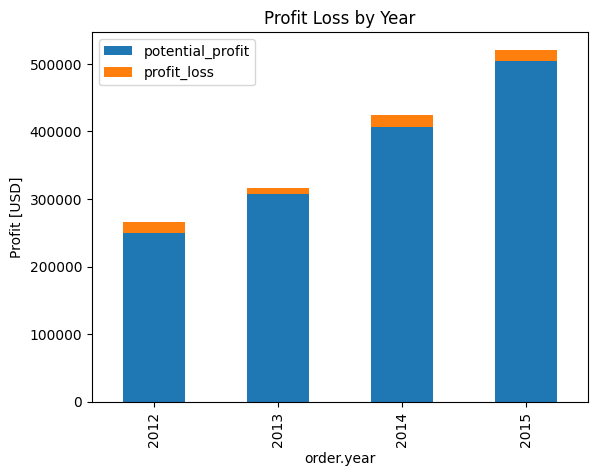

In [33]:
profit_df.plot.bar(y = ['potential_profit','profit_loss'], stacked  = True, title = 'Profit Loss by Year', ylabel = 'Profit [USD]')

<Axes: title={'center': 'Profit Loss Percentage by Year'}, xlabel='order.year', ylabel='Profit [%]'>

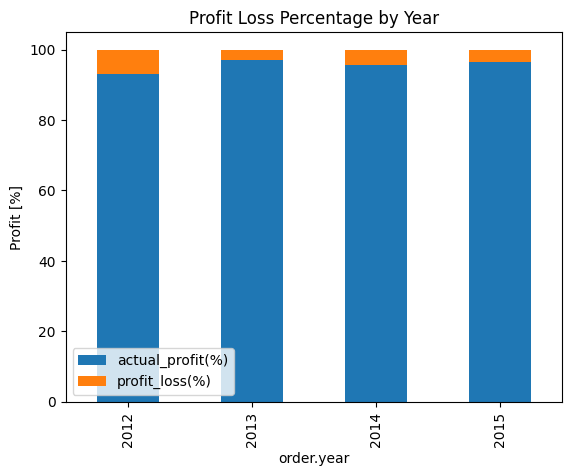

In [34]:
profit_df.plot.bar(y = ['actual_profit(%)','profit_loss(%)'], stacked  = True, title = 'Profit Loss Percentage by Year', ylabel = 'Profit [%]')

Lets analyze how many customer returned more than once? more than 5 times?
- The interpretation of return may depend on how we would like to define return: a unique order id could have multiple product_id (buying multiple items at once/given day) and we colud also have multiple quantities of each object.

If we want to count the **number of (unique) products** returned, we can analyze the data following way:

Number of returns by customer:
customer.id
AA-1031558      1
AA-106451404    1
AA-1064559      3
AA-1064564      1
AA-645137       1
Name: order.id, dtype: int64 

Number of customers by number of returns:
order.id
1     513
2     252
3     154
4      60
5      34
6      20
7      14
8       6
9       2
10      2
11      1
13      1
Name: count, dtype: int64 



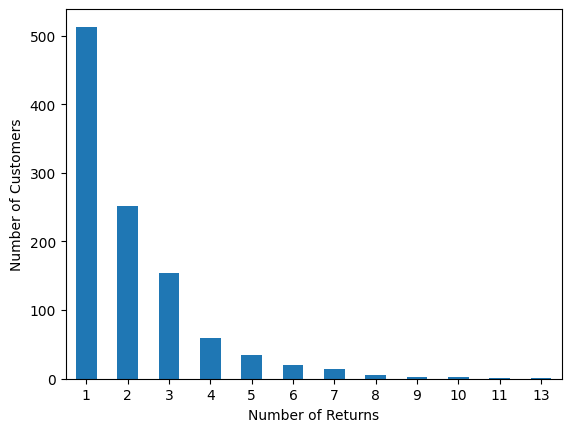

Number of customers with more than 1 return: 546
Number of customers with more than 5 returns: 46


In [35]:
return_count_by_customer = orders_returned.groupby('customer.id')['order.id'].count()

print("Number of returns by customer:")
print(return_count_by_customer.head(), "\n")

customers_by_returns = return_count_by_customer.value_counts().sort_index()
print("Number of customers by number of returns:")
print(customers_by_returns, "\n")

customers_by_returns.plot.bar(rot=0)
plt.xlabel('Number of Returns')
plt.ylabel('Number of Customers')
plt.show()

print("Number of customers with more than 1 return:", sum(return_count_by_customer > 1))
print("Number of customers with more than 5 returns:", sum(return_count_by_customer > 5))

If we want to **count the numbe of unique orders returned**, we can analyze the following way:

Number of returns by customer:
customer.id
AA-1031558      1
AA-106451404    1
AA-1064559      1
AA-1064564      1
AA-645137       1
Name: order.id, dtype: int64 

Number of customers by number of returns:
order.id
1    1039
2      20
Name: count, dtype: int64 



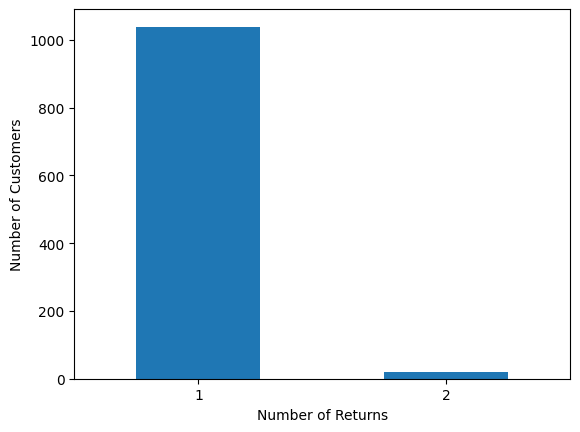

Number of customers with more than 1 return: 20
Number of customers with more than 5 returns: 0


In [36]:
return_count_by_customer = orders_returned.groupby('customer.id')['order.id'].nunique()

print("Number of returns by customer:")
print(return_count_by_customer.head(), "\n")

customers_by_returns = return_count_by_customer.value_counts().sort_index()
print("Number of customers by number of returns:")
print(customers_by_returns, "\n")

customers_by_returns.plot.bar(rot=0)
plt.xlabel('Number of Returns')
plt.ylabel('Number of Customers')
plt.show()

print("Number of customers with more than 1 return:", sum(return_count_by_customer > 1))
print("Number of customers with more than 5 returns:", sum(return_count_by_customer > 5))


To analyze which regions is most likely to return, we will calculate the likelihood using the number of returns per region divided the total number of orders per region.

In [37]:
# counts orders and returns by region
orders_by_region = orders_merged.groupby('region')['order.id'].nunique()
returns_by_region = orders_merged.query("returned == True").groupby('region')['order.id'].nunique()

# Lets put all these data into a dataframe
return_ratio_df = pd.DataFrame({
    'order_count': orders_by_region,
    'return_count': returns_by_region
})
return_ratio_df['return_ratio'] = return_ratio_df['return_count']/return_ratio_df['order_count']
return_ratio_df.sort_values(by = 'return_ratio', ascending = False)

,order_count,return_count,return_ratio
region,,,
Southern US,822,44,0.053528
Southern Europe,1098,55,0.050091
Eastern US,1401,69,0.049251
Southern Africa,241,11,0.045643
Eastern Asia,1162,53,0.045611
Oceania,1743,78,0.044750
Western US,1611,72,0.044693
Southern Asia,1346,58,0.043091
Southeastern Asia,1517,64,0.042189


Lets look at which categories of products most likely be returned:

                 order_counts  return_counts  return_rate
category                                                 
Technology              10141            444     0.043783
Furniture                9860            427     0.043306
Office Supplies         31289           1346     0.043018


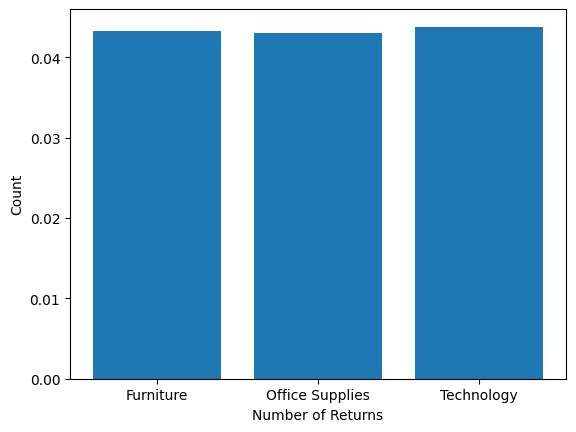

In [38]:
# Get count of orders by category
order_counts = orders.groupby('category').size()

# Get count of returned orders by category
return_counts = orders_returned.groupby('category').size()

# Calculate return rate by category
return_rate = return_counts / order_counts

# Combine into a single DataFrame
return_data = pd.DataFrame({
    'order_counts': order_counts,
    'return_counts': return_counts,
    'return_rate': return_rate
})

print(return_data.sort_values(by='return_rate', ascending=False))

# Plotting bar chart of return rate by category 

plt.bar(return_rate.index, return_rate.values)
plt.xlabel('Number of Returns')
plt.ylabel('Count')
plt.show()


Lets analyze the return likelihood in sub-category level.

In [39]:
# Get count of orders by category
order_counts = orders.groupby(['category', 'sub.category']).size()

# Get count of returned orders by category
return_counts = orders_returned.groupby(['category', 'sub.category']).size()

# Calculate return rate by category
return_rate = return_counts / order_counts

# Combine into a single DataFrame
return_data = pd.DataFrame({
    'order_counts': order_counts,
    'return_counts': return_counts,
    'return_rate': return_rate
})
print(return_data.sort_values(by = 'return_rate', ascending=False))


                              order_counts  return_counts  return_rate
category        sub.category                                          
Office Supplies Labels                2601            137     0.052672
Furniture       Tables                 861             41     0.047619
Office Supplies Art                   4864            217     0.044613
Technology      Accessories           3075            137     0.044553
                Copiers               2223             99     0.044534
Office Supplies Binders               6146            267     0.043443
Technology      Phones                3357            145     0.043193
Furniture       Bookcases             2411            104     0.043136
Office Supplies Paper                 3492            150     0.042955
Furniture       Chairs                3434            147     0.042807
                Furnishings           3154            135     0.042803
Office Supplies Supplies              2407            103     0.042792
Techno

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   row.id           51290 non-null  int64         
 1   order.id         51290 non-null  object        
 2   order.date       51290 non-null  datetime64[ns]
 3   ship.date        51290 non-null  object        
 4   ship.mode        51290 non-null  object        
 5   customer.id      51290 non-null  object        
 6   customer.name    51290 non-null  object        
 7   segment          51290 non-null  object        
 8   postal.code      9994 non-null   float64       
 9   city             51290 non-null  object        
 10  state            51290 non-null  object        
 11  country          51290 non-null  object        
 12  region           51290 non-null  object        
 13  market           51290 non-null  object        
 14  product.id       51290 non-null  objec